# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(1)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = 'data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = image.imresize(im, 36, 36)
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=True, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 128
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(128, 3, 32, 32)


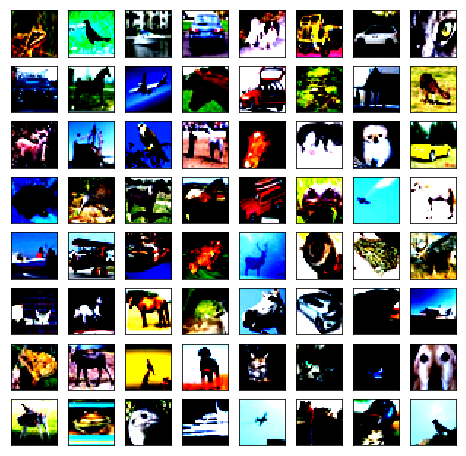

In [5]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## PyramidNet

In [6]:
def BN_ReLU_Conv(num_filter, kernel_size, strides=1, padding=0, erase_relu=False):
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            net.add(gluon.nn.Activation('relu'))
        net.add(gluon.nn.Conv2D(num_filter, kernel_size=kernel_size, strides=strides, 
                                padding=padding, use_bias=False))
    return net

def BN_ReLU(erase_relu=False):
    '''
    erase_relu : Boolean
        whether erase relu
    '''
    net = gluon.nn.HybridSequential()
    with net.name_scope():
        net.add(gluon.nn.BatchNorm(axis=1))
        if not erase_relu:
            net.add(gluon.nn.Activation('relu'))
    return net

'''
BasicBlock
'''
class BasicBlock(gluon.nn.HybridBlock):
    outchannel_ratio = 1
    def __init__(self, out_channels, strides=1, downsample=None, **kwargs):
        super().__init__(**kwargs)
        blk = self.blk = gluon.nn.HybridSequential()
        self.downsample = downsample
        self.strides = strides
        with self.name_scope():
            blk.add(BN_ReLU_Conv(out_channels, kernel_size=3, strides=strides, padding=1, erase_relu=True))
            blk.add(BN_ReLU_Conv(out_channels * BasicBlock.outchannel_ratio, kernel_size=3, strides=1, padding=1))
            blk.add(gluon.nn.BatchNorm(axis=1))
        
    def hybrid_forward(self, F, X):
        out = self.blk(X)
        if self.downsample is not None:
            shortcut = self.downsample(X)
        else:
            shortcut = X
            
        residual_channel = out.shape[1]
        shortcut_channel = shortcut.shape[1]
        
        if residual_channel != shortcut_channel:
            # zero-padded shortcut connection
            shortcut = F.array(np.pad(shortcut.asnumpy(), pad_width=((0,0),(0,residual_channel - shortcut_channel),(0,0),(0,0)),
                            mode='constant', constant_values=0))      
#         print((out + shortcut).shape)
        return out + shortcut
    
'''
Bottleneck
'''
class Bottleneck(gluon.nn.HybridBlock):
    outchannel_ratio = 4
    def __init__(self, out_channels, strides=1, downsample=None, **kwargs):
        super().__init__(**kwargs)
        blk = self.blk = gluon.nn.HybridSequential()
        self.downsample = downsample
        self.strides = strides
        with self.name_scope():
            blk.add(BN_ReLU_Conv(out_channels, kernel_size=1, erase_relu=True))
            blk.add(BN_ReLU_Conv(out_channels, kernel_size=3, strides=strides, padding=1))
            blk.add(BN_ReLU_Conv(out_channels * Bottleneck.outchannel_ratio, kernel_size=1))
            blk.add(gluon.nn.BatchNorm(axis=1))
        
    def hybrid_forward(self, F, X):
        out = self.blk(X)
        if self.downsample is not None:
            shortcut = self.downsample(X)
        else:
            shortcut = X
            
        residual_channel = out.shape[1]
        shortcut_channel = shortcut.shape[1]
        
        if residual_channel != shortcut_channel:
            # zero-padded shortcut connection
            shortcut = F.array(np.pad(shortcut.asnumpy(), pad_width=((0,0),(0,residual_channel - shortcut_channel),(0,0),(0,0)),
                            mode='constant', constant_values=0))      
#         print((out + shortcut).shape)
        return out + shortcut

def pyramidal_residual_layer(block, block_depth, fm_dim, add_rate, strides=1):
    downsample = None
    if strides != 1:
        downsample = gluon.nn.AvgPool2D(pool_size=2, strides=2)
    residual = gluon.nn.HybridSequential()
    with residual.name_scope():
        fm_dim = fm_dim + add_rate
        # first downsample layer
        residual.add(block(int(round(fm_dim)), strides, downsample))
        for i in range(1, int(block_depth)):
            tmp_fm_dim = fm_dim + add_rate
            residual.add(block(int(round(tmp_fm_dim)), 1))
            fm_dim = tmp_fm_dim

    '''
    the reason for multiply the outchannel_ratio is that, whether in BasicBlock or Bottleneck, we 
    multiply the outchannel_ratio to the last conv block to enlarge its channel.And we count the 
    channel to feed into the last classification layer.
    '''
    # fm_dim *= block.outchannel_ratio
    return residual, fm_dim

class PyramidNet(gluon.nn.HybridBlock):
    def __init__(self, depth, alpha, inchannels, num_classes, bottleneck=False, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.debug = debug
        
        if bottleneck:
            n = (depth - 2) / 9
            block = Bottleneck
        else:
            n = (depth - 2) / 6
            block = BasicBlock
            
        addrate = alpha / (3 * n * 1.0)
        featuremap_dim = inchannels # init fm_dim
            
        net = self.net = gluon.nn.HybridSequential()
        with self.name_scope():
            blk1 = gluon.nn.HybridSequential()
            blk1.add(
                gluon.nn.Conv2D(featuremap_dim, kernel_size=3, strides=1, padding=1, use_bias=False),
                gluon.nn.BatchNorm(axis=1)
            )
            
            blk2, featuremap_dim = pyramidal_residual_layer(block, n, featuremap_dim, addrate)
            blk3, featuremap_dim = pyramidal_residual_layer(block, n, featuremap_dim, addrate, strides=2)
            blk4, _ = pyramidal_residual_layer(block, n, featuremap_dim, addrate, strides=2)

            blk5 = gluon.nn.HybridSequential()
            blk5.add(
                gluon.nn.BatchNorm(axis=1),
                gluon.nn.Activation('relu'),
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
        
        net.add(blk1, blk2, blk3, blk4, blk5)
        
    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.net):
            out = blk(out)
            # if self.debug:
                # print("blk {} : {}".format(i+1, out.shape))
        return out

In [7]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d.params' % (epoch))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [ ]:
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
pyramidnet = PyramidNet(depth=110, alpha=84, inchannels=16, num_classes=10, bottleneck=False, debug=True)
# He Xavier Initializer
pyramidnet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2.))
# pyramidnet.hybridize()
train(pyramidnet, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 1.99627, Test Loss : 1.98486, Train Acc : 0.26876, Test Acc : 0.26720, Time Consume 1003.086227 s.
[Epoch 1] Train Moving Loss : 1.89126, Test Loss : 1.84777, Train Acc : 0.30293, Test Acc : 0.32460, Time Consume 940.154886 s.
[Epoch 2] Train Moving Loss : 1.73309, Test Loss : 2.10067, Train Acc : 0.32771, Test Acc : 0.29220, Time Consume 940.509786 s.
[Epoch 3] Train Moving Loss : 1.70754, Test Loss : 1.53437, Train Acc : 0.39231, Test Acc : 0.42560, Time Consume 937.846032 s.
[Epoch 4] Train Moving Loss : 1.61582, Test Loss : 1.71524, Train Acc : 0.39309, Test Acc : 0.40820, Time Consume 942.764837 s.
[Epoch 5] Train Moving Loss : 1.57801, Test Loss : 1.50236, Train Acc : 0.42873, Test Acc : 0.46840, Time Consume 943.459623 s.
[Epoch 6] Train Moving Loss : 1.57945, Test Loss : 1.48714, Train Acc : 0.42789, Test Acc : 0.45420, Time Consume 941.219342 s.
[Epoch 7] Train Moving Loss : 1.54350, Test Loss : 1.42148, Train Acc : 0.46156, Test Acc : 0.49340, Ti

In [ ]:
# import pandas as pd

# ctx = mx.gpu()
# num_epochs = 300
# lr = 0.1
# wd = 1e-4
# lr_period = 50
# lr_decay = .2

# ctx = mx.gpu()
# sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=40, growth_rate=24, 
#                       bottleneck=False, verbose=True)
# # He Xaiver Initializer
# sparsenet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(factor_type='avg', 
#                                                                    rnd_type='gaussian', magnitude=2.))
# sparsenet.hybridize()
# train(sparsenet, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

# preds = []
# for data, label in test_data:
#     output = sparsenet(data.as_in_context(ctx))
#     preds.extend(output.argmax(axis=1).astype(int).asnumpy())

# sorted_ids = list(range(1, len(test_ds) + 1))
# sorted_ids.sort(key = lambda x:str(x))

# df = pd.DataFrame({'id': sorted_ids, 'label': preds})
# df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])

# df.to_csv('submission.csv', index=False)